In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../MNIST_data', validation_size=0)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


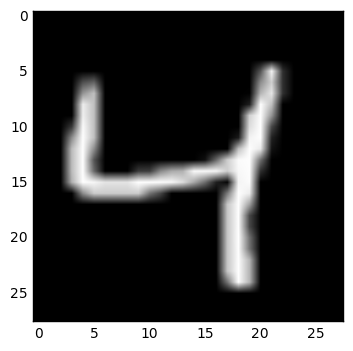

In [3]:
img = mnist.train.images[2]
img = img.reshape((28, 28))
plt.imshow(img, cmap="Greys_r")
plt.show()

In [4]:
def leaky_relu(x, alpha=0.2):
    return tf.maximum(x * alpha, x)

First, I try with simple problem. <br>
* Generator 
  1. input = latent vector (100 x 1 x 1)
  2. conv2d = kernel(4x4), leaky relu, 

### Define inputs

In [5]:
def define_inputs(batch_size):
    x_real = tf.placeholder(dtype=tf.float32, shape=[batch_size, 28, 28, 1])
#     x = tf.placeholder(dtype=tf.float32, shape=[batch_size, 4, 4, 1])
    z = tf.placeholder(dtype=tf.float32, shape=[batch_size, 100])
    return x_real, z

### Generator 

In [6]:
def generator(z, batch_size, reuse=False):
    with tf.variable_scope("generator", reuse=reuse):
        z_reshaped = tf.reshape(z, shape=[batch_size, 1, 1, 100])
        
        # first layer 
        z_padded = tf.pad(z_reshaped, [[0, 0], [3, 3], [3, 3], [0, 0]])
        W_conv1 = tf.get_variable(shape=(4, 4, 100, 1), name="conv1_Weight")
        b_conv1 = tf.get_variable(shape=1, name="conv1_bias")
        conv1 = tf.nn.conv2d(z_padded, filter=W_conv1, strides=(1, 1, 1, 1), padding="VALID") + b_conv1
        
        
        logit = conv1
        relu1 = tf.tanh(conv1)
#         relu1 = leaky_relu(conv1)
                             
        return logit, relu1

### Discriminator

Down sampling image

In [7]:
def down_sampling(img):
    # average pooling until it gets to 4x4
    # now 28 x 28
    down1 = tf.nn.avg_pool(img, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
    # now 14 x 14 
    down2 = tf.nn.avg_pool(down1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
    # now 7 x 7
    down3 = tf.nn.avg_pool(down2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
    # now 4 x 4
    return down3

In [8]:
def discriminator(x, batch_size, reuse=False, is_real=False):
    """
    gets img file and outputs 0 if fake, 1 if true
    
    x: 4x4x1 image 
    """
    with tf.variable_scope("discriminator", reuse=reuse):
        # progressive gan unique
        if is_real:
            x = down_sampling(x)
        
        # flatten the vector
        flatten = tf.reshape(x, shape=[batch_size, 4*4*1])
        
        # fc layer 
        W_fc = tf.get_variable(shape=[4*4*1, 1], name="fc_weight")
        b_fc = tf.get_variable(shape=[1], name="fc_bias")
        logits = tf.matmul(flatten, W_fc) + b_fc
        
        model = tf.nn.sigmoid(logits)
        
        return logits, model
        
    

### loss

In [9]:
def losses(x, z, batch_size):
    g_logits, g_model = generator(z=z, batch_size=batch_size)
    
    # define discriminator loss
    d_real_logits, d_real_model = discriminator(x, batch_size, is_real=True)
    d_real_labels = tf.ones_like(d_real_logits)
    d_fake_logits, d_fake_model = discriminator(g_model, batch_size, reuse=True)
    d_fake_labels = tf.zeros_like(d_fake_logits)
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels=d_real_labels, logits=d_real_logits))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels=d_fake_labels, 
                                               logits=d_fake_logits))
    d_loss = d_loss_real + d_loss_fake
    
    # define generator loss 
    g_labels = tf.ones_like(d_fake_logits)
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels=g_labels, logits=d_fake_logits))
    
    return d_loss, g_loss
    

### optimizer 

In [10]:
def opt(d_loss, g_loss):
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    
    d_opt = tf.train.AdamOptimizer(0.002).minimize(d_loss, var_list=d_vars)
    g_opt = tf.train.AdamOptimizer(0.002).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt

In [11]:
# testing down_sampling

img = mnist.train.next_batch(1)[0]
img = img.reshape((1, 28, 28, 1))
img = down_sampling(img)
print(img.shape)

(1, 4, 4, 1)


### Training 

In [16]:
tf.reset_default_graph()
batch_size = 50
x, z = define_inputs(batch_size)
d_loss, g_loss = losses(x, z, batch_size)
d_opt, g_opt = opt(d_loss, g_loss)

epochs = 20
samples = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for i in range(500):
            batch = mnist.train.next_batch(batch_size)
            
            # get image and reshape 
            batch_imgs = batch[0].reshape((batch_size, 28, 28, 1))
            batch_imgs = batch_imgs*2 - 1

            # random noise for z
            batch_z = np.random.uniform(-1, 1, size=(batch_size, 100))
            
            # run opts
            sess.run(d_opt, feed_dict={x: batch_imgs, z: batch_z})
            sess.run(g_opt, feed_dict={z: batch_z})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {z: batch_z, x: batch_imgs})
        train_loss_g = g_loss.eval({z: batch_z})
        
        print("epoch {0}, d: {1:.4f}, g: {2:.4f}".format(e, train_loss_d, train_loss_g))
        
    sample_zs = np.random.uniform(-1, 1, size=(50, 100))
    gen_samples = sess.run(generator(z, 50, reuse=True), 
                          feed_dict={z:sample_zs})
    samples.append(gen_samples)
    

epoch 0, d: 1.1158, g: 0.7834
epoch 1, d: 1.3309, g: 0.7690
epoch 2, d: 1.3571, g: 0.6780
epoch 3, d: 1.3758, g: 0.7061
epoch 4, d: 1.3194, g: 0.7396
epoch 5, d: 1.3339, g: 0.7541
epoch 6, d: 1.3254, g: 0.7345
epoch 7, d: 1.3513, g: 0.7217
epoch 8, d: 1.3389, g: 0.7389
epoch 9, d: 1.3775, g: 0.7161
epoch 10, d: 1.4074, g: 0.6758
epoch 11, d: 1.4004, g: 0.6828
epoch 12, d: 1.3639, g: 0.7071
epoch 13, d: 1.3937, g: 0.7003
epoch 14, d: 1.3896, g: 0.6829
epoch 15, d: 1.3600, g: 0.7175
epoch 16, d: 1.3665, g: 0.7188
epoch 17, d: 1.3870, g: 0.6975
epoch 18, d: 1.3641, g: 0.7083
epoch 19, d: 1.3980, g: 0.6762


In [ ]:
b = mnist.train.next_batch(1)
print(b[0].shape)
k = b[0].reshape((1, 28, 28, 1))

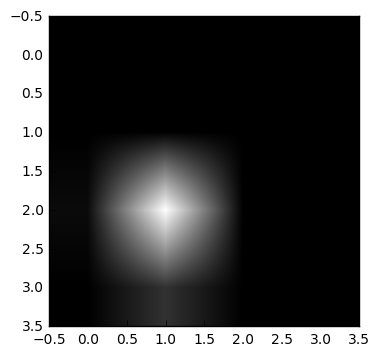

In [102]:
# generated imgs
kk = samples[0]
sample_img = kk[1][16]
img = sample_img[:, :, 0]
plt.imshow(img, cmap="gray")
plt.show()

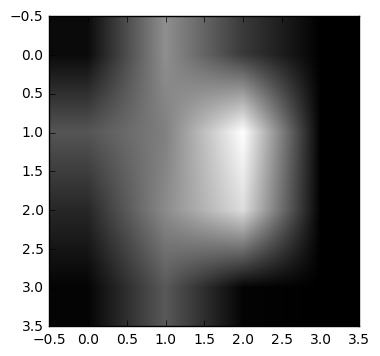

In [110]:
# real imgs
sample_img = down_sampling(
    mnist.train.next_batch(1)[0].reshape((1, 28, 28, 1)))
img = sample_img[0, :, :, 0]
processed = None
with tf.Session() as sess:
    processed = sess.run(img)
plt.imshow(processed, cmap="gray")
plt.show()